In [1]:
from __future__ import division, print_function, absolute_import

#Supervised Machine Learning Break Out:
Separating Stars and Galaxies from SDSS 
========

#####Version 0.1

Many (nearly all?) of the science applications for LSST data will rely on the accurate separation of stars and galaxies in the LSST imaging data. As an example, imagine measuring galaxy clustering without knowing which sources are galaxies and which are stars. During this exercise, we will utilize supervised machine-learning methods to separate extended (galaxies) and point sources (stars, QSOs) in imaging data. These methods are highly flexible, and as a result can classify sources at higher fidelity than methods that simply make cuts in a low-dimensional space.

***
By AA Miller (c) 2016 Jul 11

In [2]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

##Problem 1) Obtain and Examine Training Data

As a reminder, for supervised-learning problems we use a training set, sources with known labels, i.e. they have been confirmed as normal stars, QSOs, or galaxies, to build a model to classify new observations where we do not know the source label.

The training set for this exercise will be pulled from SDSS. For features, we will start with each Magnitude measured in the $r$-band. This results in a total of 8 features (more than the Iris data set, but significantly fewer than everything in SDSS).

The first step when pursuring a machine learning problem is to examine the potential training set. **A machine-learning model is only as good as its training set.** This point cannot be emphasized enough. Machine-learning models are data-driven, they do not capture any physical theory, and thus it is essential that the training set satisfy several criteria. Two of the most important criteria for a good training set are: 

+ the training set should be unbiased [this is actually really hard to achieve in astronomy since most surveys are magnitude limited]
+ the training set should be representative of the (unobserved or field) population of sources [a training set with no stars will yield a model incapable of discovering point sources]

As a first step (and this is always a good idea), we are going to examine the training set to see if anything suspicious is going on. We will use [`astroquery`](https://astroquery.readthedocs.io/en/latest/) to directly access the SDSS database, and store the results in an [`astropy` Table](http://astropy.readthedocs.org/en/latest/table/). 

**Note** The SDSS API for `astroquery` is not standard for the package, which leads to a warning. This is not, however, a problem for our purposes.

In [3]:
# execute this cell
from astroquery.sdss import SDSS  # enables direct queries to the SDSS database

/Users/adamamiller/anaconda/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


While it is possible to look up each of the names of the $r$-band magnitudes in the [SDSS `PhotoObjAll` schema](https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx?cmd=description+PhotoObjAll+U#&&history=description+PhotoObjAll+U), the schema list is long, and thus there is a chance of missing one column. Better to identify the desired columns using the database itself:

    SELECT COLUMN_NAME
    FROM INFORMATION_SCHEMA.Columns
    WHERE table_name = 'PhotoObjAll' AND 
    COLUMN_NAME LIKE '%Mag/_r' ESCAPE '/'

which returns the following list of columns: `psfMag_r, fiberMag_r, fiber2Mag_r, petroMag_r, deVMag_r, expMag_r, modelMag_r, cModelMag_r`. 

We now select these magnitude measurements for 10000 stars and galaxies from SDSS. Additionally, we join these results with the `SpecObjAll` table to obtain their spectroscopic classifications, which will serve as labels for the machine-learning model.

**Note** - the SDSS database contains duplicate observations, flagged observations, and non-detections, which we condition the query to exclude (as explained further below). We also exclude quasars, as the precise photometric classification of these objects is ambiguous: low-$z$ AGN have resolvable host galaxies, while high-$z$ QSOs are point-sources. Query conditions:

* `p.mode = 1` select only the primary photometric detection of a source
* `s.sciencePrimary = 1` select only the primary spectroscopic detection of a source (together with above, prevents duplicates)
* `p.clean = 1` the SDSS [`clean`](http://www.sdss.org/dr12/algorithms/photo_flags_recommend/) flag excludes flagged observations and sources with non-detections
* `s.class != 'QSO'` removes potentially ambiguous QSOs from the training set

In [4]:
TSquery = """SELECT TOP 10000 
             p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
             p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
             s.class
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
             ORDER BY p.objid ASC
               """
SDSSts = SDSS.query_sql(TSquery)
SDSSts

psfMag_r,fiberMag_r,fiber2Mag_r,petroMag_r,deVMag_r,expMag_r,modelMag_r,cModelMag_r,class
float64,float64,float64,float64,float64,float64,float64,float64,str6
18.50319,18.65275,19.33509,17.54539,17.31526,17.58132,17.58132,17.48715,GALAXY
19.02659,19.32441,19.80892,19.05827,19.03468,19.03111,19.03111,19.03111,STAR
19.8809,19.77895,20.46623,19.3534,19.1864,19.35493,19.35493,19.24559,GALAXY
22.03563,22.06141,22.68416,21.51795,21.03554,21.31751,21.31751,21.31751,GALAXY
21.56726,21.57312,22.22178,20.4583,19.93309,20.39825,20.39819,20.20402,GALAXY
18.66813,18.75309,19.36792,17.83372,17.69468,17.89914,17.6947,17.75269,GALAXY
20.19068,20.33947,20.93226,19.77666,19.63458,19.74873,19.74872,19.74873,GALAXY
19.41619,19.38348,20.15486,17.67687,17.16815,17.63962,17.63962,17.63962,GALAXY
18.88878,18.91179,19.57415,17.3317,17.02896,17.43539,17.02898,17.06256,GALAXY


To reiterate a point from above: data-driven models are only as good as the training set. Now that we have a potential training set, it is essential to inspect the data for any peculiarities. 

**Problem 1a** Visualize the training set (an intentially open-ended question, think back to yesterday's exercises) to inspect the features and whether or not they may be useful for a machine-learning model. 

*Hint* `astropy Tables` can be converted to `pandas DataFrames` with the `.to_pandas()` operator, which may be helpful.

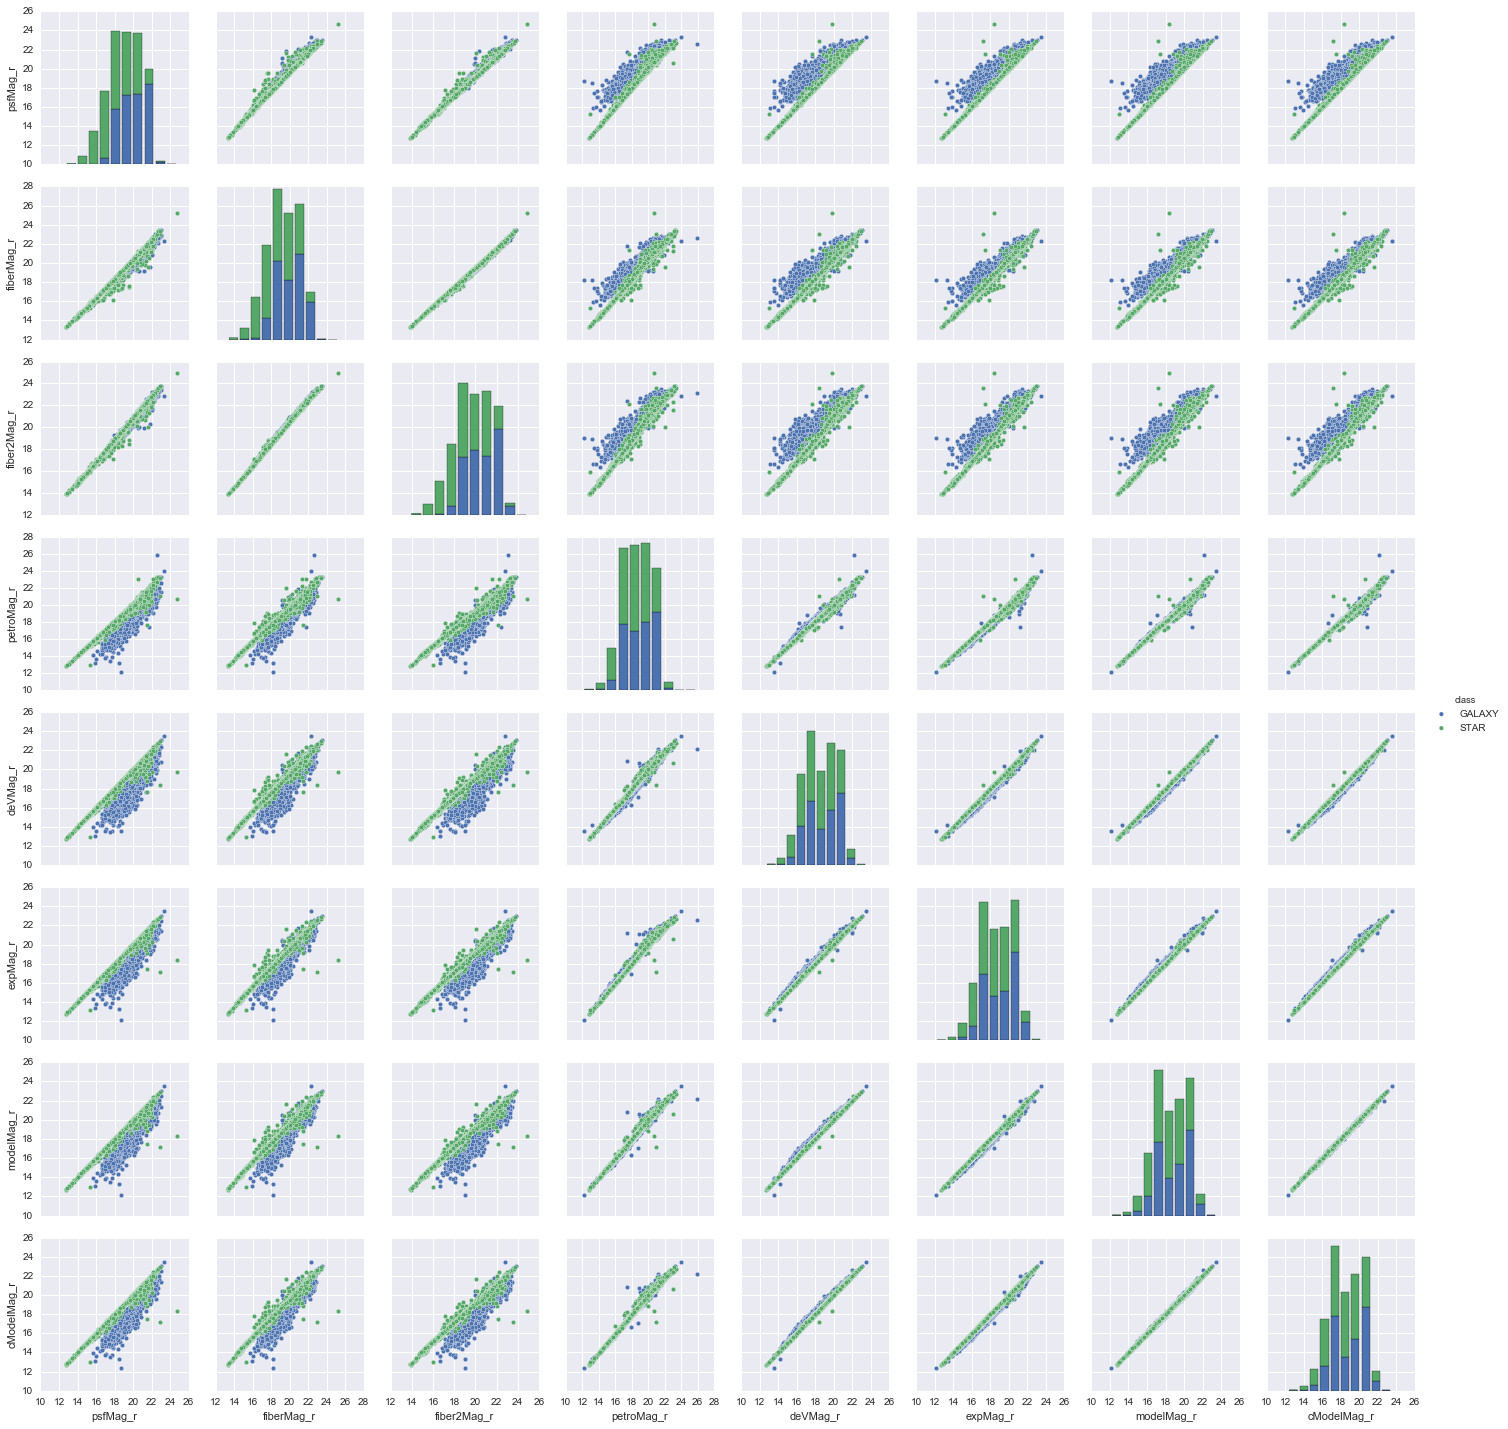

**Problem 1b** Can the acquired training set be used to separate stars and galaxies? [Write your reasoning below]

*Type response to 1b here* 

To test the efficacy of the machine-learning model we need to separate the spectroscopic sample into an independent training and validation set. There is no set number for the precise fraction of the data to include in the validation set, and typical choices vary between $\sim{0.2}-0.4$. For this problem we will adopt 0.3.

[`sklearn.cross_validation`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cross_validation) has a handy function [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html), which will simplify this process.

**Problem 1c** Split the 10k spectroscopic sources 70-30 into training and validation sets. Save the results in arrays called: `train_X, train_y, val_X, val_y`, respectively. Use `rs` for the `random_state` when selecting a random portion of the spectroscopic set.

*Hint - recall that `sklearn` utilizes X, a 2D `np.array()`, and y as the features and labels arrays, respecitively.*

In [29]:
from sklearn.cross_validation import train_test_split
rs = 23  # we are in Chicago after all

# complete

X = np.array( # complete
y = np.array( # complete

train_X, val_X, train_y, val_y = train_test_split( X, y,  # complete

##Problem 2) Feature Engineering

It has been said that all machine learning is an exercise in feature engineering. In other words, all machine-learning are worthless without the correct set of features. Here we will quickly examine the set of features selected above to test how well they separate stars and galaxies. We will use the Random Forest (RF) algorithm [Breiman 2001](http://link.springer.com/article/10.1023/A:1010933404324) as implemented by `sklearn`. [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is part of the [`sklearn.ensemble`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) module. 

**Problem 2a** Train a RF model on your training set, and determine the accuracy of the model using the validation set. Set `n_estimators`, the number of trees in the forest, to 25 in the model.

*Hint - you may find [`sklearn.metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) useful for this exercise.*

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

RFmod =  # complete

val_preds =  # complete

print("The raw features produce a model with accuracy ~{:.4f}".format(accuracy_score(val_y, val_preds)))

The raw features produce a model with accuracy ~0.9703


Not bad for a model with no optimization! 

For reference, the SDSS photometric classifier uses a [single hard cut](http://www.sdss.org/dr12/algorithms/classify/#photo_class) to separate stars and galaxies in imaging data:

$$\mathtt{psfMag} - \mathtt{cmodelMag} > 0.145,$$

sources that satisfy this criteria are considered galaxies. 

**Problem 2b** Determine the accuracy of the SDSS photometric model on the 10k spectroscopic sources obtained above. This accuracy will represent the "benchmark" upon which we hope to improve with the machine learning model. 

In [73]:
 # complete
    
print("The SDSS phot model produces an accuracy ~{:.4f}".format(accuracy_score(SDSSts['class'], SDSSphot_class)))

The SDSS phot model produces an accuracy ~0.9634


One advantage of the SDSS model is that the magnitude measurements have been normalized. The SDSS spectroscopic training set is biased towards stars at bright the end, and towards galaxies at the faint end. (This can be quickly confirmed by plotting histograms, or better yet KDEs, of each.) While the universe *is biased* in this way, it is not clear that the SDSS targeting function properly captured this bias. Thus, we will attempt to engineer the features to remove this bias (similar to SDSS). 

**Problem 2c** Normalize the feature vector relative to `psfMag_r`, and refit the RF model to see if the accuracy improves when predicting the class of sources in the validation set. 

*Hint - be sure you apply the eaxct same normalization to both the training and validation set*

In [77]:
train_Xnorm =  # complete
val_Xnorm =  # complete

RFmod =  # complete
RFmod.fit(  # complete
val_predsNorm = RFmod.predict(  # complete

print("The normalized features produce a model with accuracy ~{:.4f}".format(accuracy_score(val_y, val_predsNorm)))

The normalized features produce a model with accuracy ~0.9713


**Problem 2d** How does the accuracy of each of these 3 models compare? 

If normalizing the features did not improve the accuracy of the model, can you think of any reasons why?

*Hint - think about the name of the algorithm.*

*Type response to 2d here* 

While there are additional feature engineering steps one could take: 

* remove correlated features 
* add contextual features (e.g., galactic latitude? distance to nearest neighbor?)
* create new features (ellipticity measurements?)

we will stop at this stage. Generally speaking, RF is immune to correlated features (this is not true of all machine-learning algorithms), contextual features, especially galactic latitude, can bias the model due to the manner in which the training data were obtained. 

Finally, we exploit one of the most novel aspects of RF - the ability to measure the relative importance of each feature. This is accomplished by randomly shuffling the values of a particular feature, and examining the decrease in performance of the model's overall accuracy. The relative feature importances can be accessed using the `.feature_importances_` attribute associated with the `RandomForestClassifer()` class. The higher the value, the more important feature. 

**Problem 2e** Calculate the relative importance of each feature. Which feature is most important? Can you make sense of the feature ordering? 

*Hint - do not dwell too long on the final ordering of the features.*


In [107]:
 # complete
    

print("The relative importance of the features is: \n{:s}".format(  # complete

[ 0.07642965  0.0167598   0.08676947  0.26527494  0.17775416  0.16487131
  0.21214067]
The relative importance of the features is: 
psfMag_r - deVMag_r, 
psfMag_r - cModelMag_r, 
psfMag_r - expMag_r, 
psfMag_r - modelMag_r, 
psfMag_r - petroMag_r, 
psfMag_r - fiberMag_r, 
psfMag_r - fiber2Mag_r


In some cases, the final step in feature engineering is identifying the useful features and removing those that are noisy and/or provide no information. Again, RF is relatively immune to these problems, and in this case (7 features) there are few features. Thus, we do not need to remove any features. Nevertheless, we see that the `psfMag_r -fiber2Mag_r` feature has very little importance. This is due to the high correlation between `fiberMag_r` and `fiber2Mag_r`. It is likely we could remove one of these features without harming the model. We could even measure the model improvement (if any) via cross-validation or the validation set. 

##Problem 3) Optimize Model Tuning Parameters

All machine-learning models have tuning parameters. In brief, these parameters capture the smoothness of the model in the multidimentional-feature space. Whether the model is smooth or coarse is an application dependent problem, though one should always be weary of over-fitting or under-fitting the data. Generally speaking, RF (and most tree-based methods) have 3 flavors of tuning parameter:

1. $N_\mathrm{tree}$ - the number of trees in the forest `n_estimators` (default: 10) in `sklearn`
2. $m_\mathrm{try}$ - the number of (random) features to explore as splitting criteria at each node `max_features` (default: `sqrt(n_features)`) in `sklearn`
3. Pruning criteria - defined stopping criteria for ending continued growth of the tree, there are [many choices](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for this in `sklearn` (My preference is `min_samples_leaf` (default: 1) which sets the minimum number of sources allowed in a terminal node, or leaf, of the tree)

An important lesson at this stage: to avoid overfitting the validation set cannot be used to optimize the tuning parameters. This leaves two potential options: further split the training set into a training and test set or via cross validation (CV). As a reminder, in CV, the training set is partitioned, and sources outside each individual partition are used to predict the class of sources within the partition. This procedure is then repeated for each partition, so that every source in the training set has exactly one prediction, allowing a measurement of the cross-validation error. The most common form of CV is known as K-fold, where the training set is divided into $k$ partitions of equal size. In order of increasing computational time, typical choices for $k$ are 2, 3, 10, or $N$, where $N$ is the total number of sources in the training set, this is known as leave-one-out CV.

Fortunately, `scikit-learn` has a [`cross validation` module](http://scikit-learn.org/stable/modules/cross_validation.html) that simplifies CV. The CV accuracy can be obtained via [`cross_validation.cross_val_score()`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html), which requires the model, training features, and training classes as arguments. The default is $k = 3$ folds. Finally, note that this method uses [Stratified K-folds](http://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold), which is slightly different from the procedure described above.

**Problem 3a** Determine the 5-fold CV accuracy for the training set.

In [124]:
from sklearn.cross_validation import cross_val_score

CVscores = cross_val_score(  # complete

print(CVscores)
print("The CV accuracy for the training set is {:.4f}".format(np.mean(CVscores)))

[ 0.96288365  0.97073519  0.96714286  0.96926376  0.97069335]
The CV accuracy for the training set is 0.9681


Now, let's try to develop some intuition for the effects of changing the tuning parameters.

**Problem 3b** Determine the 5-fold CV accuracy for models with $N_\mathrm{tree}$ = 1, 10, 100. 

In [125]:
CVscores1 = cross_val_score(  # complete

CVscores10 = cross_val_score(  # complete

CVscores100 = cross_val_score(  # complete

print("The CV accuracy for 1, 10, 100 trees is {:.4f}, {:.4f}, {:.4f}".format(  # complete

The CV accuracy for 1, 10, 100 trees is 0.9451, 0.9671, 0.9683


From the above results, we can see that 1 tree is likely too few, while the results seem to be stabilizing with $N_\mathrm{tree} \gtrsim 10$. So - how does one actually determine the optimal set of tuning parameters? Brute force. At least in our case we will use brute force, as the data set and number of tuning parameters is small (there are alternative approaches that are less time consuming when this isn't the case). We will perform a grid search over the three tuning parameters, measuring the CV accuracy at each point within the 3D grid, and picking the point with the highest accuracy. Two general rules of thumb: (i) if the highest accuracy occurs at the edge of the grid, it is best to refit a new grid centered on that point, and (ii) the results should be stable in the vicinity of the grid maximum. If this is not the case, then it is likely that the model has been overfit. 

Once again, `scikit-learn` has made our lives significantly easier by providing a convenience function [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html), which will enable a single line call to optimize the model. One thing to keep in mind, which likely won't be a problem here, depending on how `GridSearchCV` is called it is possible to run into memory issues.

**Problem 3c** Perform a **3-fold** CV grid search to optimize the RF star-galaxy model. Remember the rules of thumb. What are the optimal tuning parameters for the model?

*Hint - think about the computational runtime based on the number of points in the grid. Do not start with a very dense or large grid.*

In [137]:
from sklearn.grid_search import GridSearchCV

grid_results = GridSearchCV(  # complete
grid_results.fit(  # complete



The optimal parameters are:
max_features: 3
n_estimators: 300
min_samples_leaf: 10


In [138]:
print("The optimal parameters are:")
for key, item in grid_results.best_params_.items(): # warning - slightly different meanings in Py2 & Py3
    print("{}: {}".format(key, item))

The optimal parameters are:
max_features: 3
n_estimators: 300
min_samples_leaf: 10


##Problem 4) Evaluating the Accuracy of the Model

Now that the model has been fully optimized, we can estimate its accuracy with the validation set. This estimate provides insight for the model accuracy expected for photometric data where we do not have spectroscopy, and thus cannot validate the predictions. 

**Problem 4a** Train a RF model using the optimized tuning parameters from 3c, and estimate the classification accuracy of the model using the validation set. 

In [160]:
RFmod = RandomForestClassifier( # complete
    
val_predsNorm = RFmod.predict(  # complete

print("The accuracy of the optimized model is ~{:.4f}".format(accuracy_score(val_y, val_predsNorm)))

The accuracy of the optimized model is ~0.9743


A standard method for evaluating classification models is the confusion matrix, which summarizes both the accuracy for each individual class, as well the most-likely misclassifications for each class. [For the 2 class problem, such as ours, these quantities are essentially one and the same, but for multi-class problems this is highly helpful.] In examining the matrix, "confusion" for the classifier is summarized. In a confusion matrix, one axis shows the true class and the other shows the predicted class. For a perfect classifier all of the power will be along the diagonal, while confusion is represented by off-diagonal signal. 

Like almost everything else we have encountered during this exercise, `scikit-learn` makes it easy to compute a [`confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) within the `sklearn.metrics` module.

**Problem 4b** Calculate (and examine) the confusion matrix for the training set from Part 1.

In [143]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix( # complete
print(cm)

[[1346   64]
 [  23 1567]]


Visual representations are often the most useful means for interpreting the confusion matrix (this is especially true for multiclass problems). 

**Problem 4c** Plot the *normalized* confusion matrix for the validation set.

*Hint - you might find the [`sklearn` confusion matrix tutorial](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#example-model-selection-plot-confusion-matrix-py) helpful.*

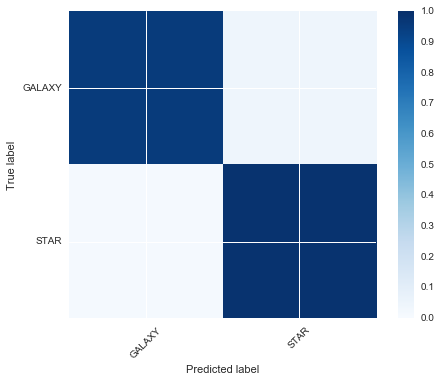

In [159]:
cmNorm =  # complete

plt.imshow( # complete
plt.colorbar()
 # complete

**Note** - if your plot looks a little funny, that is likely because you imported seaborne earlier. Remember, `import seaborne` also changes defaults, but you can change the default appearance of `seaborne`. 

For this problem, where the accuracy is very high and there are only two classes, the confusion matrix is not necessarily that insightful. Another common machine-learning evalutation tool is the [Receiver Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), which is espeically useful for threshold tuning. 

One of the useful properties of RF models, which has not been mentioned yet, is that RF provides probabilistic predictions. In short, a source that is classified as a star in 95% of trees is much more likely to be a star than a source classified as such in only 53% of trees. [It is better to think of these probabilities as relative rankings based on the training set rather than true probabilities. Biases in the training set, which will almost certainly always exist in astronomy, result in "probabilities" that are not properly calibrated.] These "probabilities" are highly useful because they allow us to tune the purity and completeness of the final model, and they can be access for some (not all) sklearn models using the `.predict_proba()` function.

The model output is tuned via the ROC curve (or the somewhat related [precision-recall curve](https://en.wikipedia.org/wiki/Precision_and_recall)), which plots the  the true positive rate (TPR) against the false positive rate (FPR):

$$ \mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}},$$

$$ \mathrm{FPR} = \frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}},$$

where $\mathrm{TP}$ is the number of true positives, $\mathrm{FN}$ is the number of false negatives, $\mathrm{FP}$ is the number of false positives, and $\mathrm{TN}$ is the number of true negatives. The ideal model has high TPR and low FPR. The ROC curve comes from varying the classification decision threshold from 1 to 0.

Once again, `scikit-learn` comes to the rescue by making it easy to calculate ROC curves with [`roc_curve`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) in the `sklearn.metrics` module.

**Problem 4d** Calculate and plot the ROC curve for stars as determined by the validation set. 

*Hint - for this problem, you'll want to recast `y` as an integer array, so that the definition of TP and FP is unambiguous.*

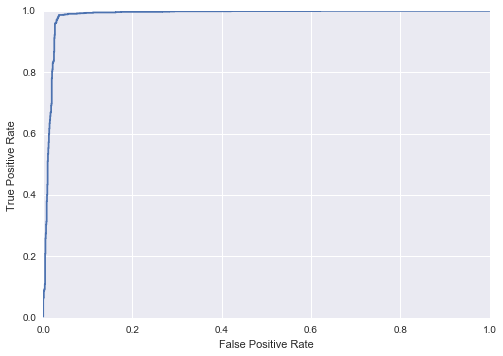

In [170]:
from sklearn.metrics import roc_curve

train_yInt = # complete
# complete
val_yInt = # complete
# complete

RFmod = RandomForestClassifier(# complete
# complete
val_predsProba = # complete

fpr, tpr, thresh = roc_curve( # complete
        
plt.plot( # complete
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

The ROC curve should come very close to (0, 1), which is the sign of a good model (and with ~97% accuracy we already knew we have a pretty good model). We will now explore the results of thresholding. Suppose you are searching for supernovae in a time domain survey, and it is essential you examine transients in as many galaxies as possible. While searching, there will be many false positives in the form of stars, thus, you need a model that rejects stars (high TPR) with a very low FPR (does not misclassify galaxies).

**Problem 4e** Determine the classification threshold and TPR corresponding to a FPR = 0.01.

In [172]:
# complete

print("At FPR = 0.01, the TPR = {:.3f} corresponding to decision threshold = {:.3f}".format( # complete

At FPR = 0.01, the TPR = 0.434 corresponding to decision threshold = 0.985


**That's it!** You now have the basic outline necessary to create a full-blown, publication-ready machine-learning model.

Now, before you run off importing `sklearn` left and right and re-writing all your code to use machine-learning, remember: you should always, always, always, always (how many times can I copy paste the word "always"?), always be extremely concerned about the bias present in your training set. (Even after the paper is accepted, the community loves it, and you've discovered some new great thing - you should be worried about the training set.) In my (AAM) personal experience, the vast majority of my time as a machine-learning practicioner is spent chasing down unusual things in the training set. So, proceed with caution. 

If you have time - try the challenge problem below, which should reinforce my words of caution. 

##Challenge Problem) Taking the Plunge
###Applying the model to field data

QSOs are unresolved sources that look like stars in optical imaging data. We will now download photometric measurements for 10k QSOs from SDSS and see how accurate the RF model performs for these sources. 

In [184]:
QSOquery = """SELECT TOP 10000 
             p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
             p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
             s.class
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class = 'QSO'
             ORDER BY s.specobjid ASC
               """
QSOts = SDSS.query_sql(QSOquery)

**Challenge 1** Calculate the accuracy with which the model classifies QSOs based on the 10k QSOs selected with the above command. How does that accuracy compare to that estimated by the validation set? 

In [185]:
# complete

print("The RF model correctly classifies ~{:.4f} of the QSOs".format(accuracy_score( # complete

The RF model correctly classifies ~0.8763 of the QSOs


**Challenge 2** Can you think of any reasons why the performance would be so much worse for the QSOs than it is for the stars? Can you obtain a ~.97 accuracy when classifying QSOs?

In [189]:
# As discussed above, low-z AGN have resolved host galaxies which will confuse the classifier, 
# this can be resolved by only selecting high-z QSOs (z > 1.5)

QSOquery = """SELECT TOP 10000 
             p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
             p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
             s.class
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class = 'QSO'
             AND s.z > 1.5
             ORDER BY s.specobjid ASC
               """
QSOts = SDSS.query_sql(QSOquery)

qso_X = # complete
qso_y = # complete
qso_Xnorm = # complete

qso_preds = RFmod.predict( # complete

print("The RF model correctly classifies ~{:.4f} of the QSOs".format(accuracy_score( # complete

The RF model correctly classifies ~0.9898 of the QSOs


##Uber Challenge Problem) The 3-class problem

**Uber Challenge** Create a 3 class RF model that separates stars, galaxies, and QSOs in SDSS imaging data. Limit the size of your training set to $< 25000$ sources, but that's it as far as suggestions and hints are concerned. Can you achieve a classification accuracy around 97%?

In [ ]:
import # brokenBrain